<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-X.-Template" data-toc-modified-id="Case-X.-Template-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 2</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Modes-and-training" data-toc-modified-id="Modes-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modes and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 2
Tuomas Tilli<br>
Last edited: 04.03.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# Background

The aim of this Notebook is to train a convolutional neural network to to recognize characteristics of pneumonia from medical chest x-ray images. If successful, this kind of model could prove helpful in diagnosis of the disease. The dataset consisting of x-ray images is cited below:

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/rscbjbr9sj.2

In [15]:
# Imports

%pylab inline
import numpy as np
import pandas as pd
import random
import os
import shutil
import time
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives, SensitivityAtSpecificity
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
print('tf version = ', tf.__version__)

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print("Found GPU at: {}".format(device_name))

Populating the interactive namespace from numpy and matplotlib
tf version =  2.1.0
Found GPU at: /device:GPU:0


C:\Users\Tuomas\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data

The downloaded dataset contained separate training and testing sets in their own respective directories. The images of healthy and sick patients were split into separate directories.

Data augmentation creates additional images by introducing various transformations to the original ones. Using the same ImageDataGenerator for training and validation samples can lead to problems due to the validation images also getting augmented. Hence there is a need for a separate validation set residing in a separate directory, which would be used by the validation data generator. The script below was used to split the original dataset for training (60%), validation (20%) and testing (20%).

In [16]:
# Create base directory for the files

original_dir = 'C:/Users/Tuomas/jupyter-notebooks/Case2/ChestXRay2017/chest_xray/'

base_dir = 'C:/Users/Tuomas/jupyter-notebooks/Case_2/Case2_XRay'
os.mkdir(base_dir)

In [17]:
# Create subdirectories for training, validation and testing

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [18]:
# Create subdirectories for the two classes

train_normal_dir = os.path.join(train_dir, 'NORMAL')
os.mkdir(train_normal_dir)
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
os.mkdir(train_pneumonia_dir)
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
os.mkdir(validation_normal_dir)
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')
os.mkdir(validation_pneumonia_dir)
test_normal_dir = os.path.join(test_dir, 'NORMAL')
os.mkdir(test_normal_dir)
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')
os.mkdir(test_pneumonia_dir)

In [19]:
# Create lists with training file names

original_train_dir = os.path.join(original_dir,'train')
original_test_dir = os.path.join(original_dir,'test')

train_names_normal = os.listdir(os.path.join(original_train_dir,'NORMAL'))
train_names_pneumonia = os.listdir(os.path.join(original_train_dir,'PNEUMONIA'))

test_names_normal = os.listdir(os.path.join(original_test_dir,'NORMAL'))
test_names_pneumonia = os.listdir(os.path.join(original_test_dir,'PNEUMONIA'))

print('Train directory:')
print(len(train_names_normal),'normal images')
print(len(train_names_pneumonia),'pneumonia images') 

print('Test directory:')
print(len(test_names_normal),'normal images')
print(len(test_names_pneumonia),'pneumonia images') 

Train directory:
1349 normal images
3884 pneumonia images
Test directory:
234 normal images
390 pneumonia images


In [20]:
# Shuffle the lists in random order

random.shuffle(train_names_normal)
random.shuffle(train_names_pneumonia)
random.shuffle(test_names_normal)
random.shuffle(test_names_pneumonia)

In [21]:
original_train_normal_dir = os.path.join(original_train_dir,'NORMAL')
original_train_pneumonia_dir = os.path.join(original_train_dir,'PNEUMONIA')
original_test_normal_dir = os.path.join(original_test_dir,'NORMAL')
original_test_pneumonia_dir = os.path.join(original_test_dir,'PNEUMONIA')

# Copy original training data of type normal to new directories in proper ratios

for fname in train_names_normal[:809]:
    src = os.path.join(original_train_normal_dir, fname)
    dst = os.path.join(train_normal_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in train_names_normal[809:1079]:
    src = os.path.join(original_train_normal_dir, fname)
    dst = os.path.join(validation_normal_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in train_names_normal[1079:]:
    src = os.path.join(original_train_normal_dir, fname)
    dst = os.path.join(test_normal_dir, fname)
    shutil.copyfile(src, dst)

In [22]:
# Copy original training data of type pneumonia to new directories in proper ratios

for fname in train_names_pneumonia[:2330]:
    src = os.path.join(original_train_pneumonia_dir, fname)
    dst = os.path.join(train_pneumonia_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in train_names_pneumonia[2330:3107]:
    src = os.path.join(original_train_pneumonia_dir, fname)
    dst = os.path.join(validation_pneumonia_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in train_names_pneumonia[3107:]:
    src = os.path.join(original_train_pneumonia_dir, fname)
    dst = os.path.join(test_pneumonia_dir, fname)
    shutil.copyfile(src, dst)

In [23]:
# Copy original test data of type normal to new directories in proper ratios

for fname in test_names_normal[:140]:
    src = os.path.join(original_test_normal_dir, fname)
    dst = os.path.join(train_normal_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in test_names_normal[140:187]:
    src = os.path.join(original_test_normal_dir, fname)
    dst = os.path.join(validation_normal_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in test_names_normal[187:]:
    src = os.path.join(original_test_normal_dir, fname)
    dst = os.path.join(test_normal_dir, fname)
    shutil.copyfile(src, dst)

In [24]:
# Copy original test data of type pneumonia to new directories in proper ratios

for fname in test_names_pneumonia[:234]:
    src = os.path.join(original_test_pneumonia_dir, fname)
    dst = os.path.join(train_pneumonia_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in test_names_pneumonia[234:312]:
    src = os.path.join(original_test_pneumonia_dir, fname)
    dst = os.path.join(validation_pneumonia_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in test_names_pneumonia[312:]:
    src = os.path.join(original_test_pneumonia_dir, fname)
    dst = os.path.join(test_pneumonia_dir, fname)
    shutil.copyfile(src, dst)

In [25]:
# Check the contents of the new directories

print('Total normal training samples',len(os.listdir(train_normal_dir)))
print('Total pneumonia training samples',len(os.listdir(train_pneumonia_dir)))

print('Total normal validation samples',len(os.listdir(validation_normal_dir)))
print('Total pneumonia validation samples',len(os.listdir(validation_pneumonia_dir)))

print('Total normal test samples',len(os.listdir(test_normal_dir)))
print('Total pneumonia test samples',len(os.listdir(test_pneumonia_dir)))

Total normal training samples 949
Total pneumonia training samples 2564
Total normal validation samples 317
Total pneumonia validation samples 855
Total normal test samples 317
Total pneumonia test samples 855


In [26]:
#train_dir = './Case2_XRay/train'
#validation_dir =  './Case2_XRay/validation'
#test_dir =  './Case2_XRay/test'

TS = (150,150)  # Image Size
BS = 16        # Batch Size

# ImageDataGenerators for test, validation and train sets
# Data augmentation was used for the training generator (rotation and vertical flip)
# All models use the same image data from these generators

print('Training:')
tg = ImageDataGenerator(rescale=1./255, #zoom_range=0.3, 
                        rotation_range = 5, 
                        vertical_flip=True)
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary'
)

print('Validation:')
devg = ImageDataGenerator(rescale=1./255)
dev_generator = devg.flow_from_directory(
    validation_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary'
)

print('Testing:')
testg = ImageDataGenerator(rescale=1./255)
test_generator = testg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary'
)

print(train_generator.class_indices)

Training:
Found 3512 images belonging to 2 classes.
Validation:
Found 1172 images belonging to 2 classes.
Testing:
Found 1172 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


# Models and training

Input shape for the CNN was an image of 150x150 pixels and a tensor depth of 3 (color channels). Pooling was introduced after the convolutional layers and was done with a 2x2 array. Chosen batch size was 16. Number of epochs was 12.

A variable number of convolutional layers and filters (feature detectors) were experimented with. Three different structures for the dense classifier part of the network were also tried out. The amount of dense layers and amount of neurons in each layer were altered for each model. 

Rectifier activation function was used for the convolutional layers of every model tested. The output of the CNN was flattened for feeding into the fully connected classifier. Dense layers also used rectifier activation function and the final output layer of 1 neuron used a sigmoid activation function because there needs to be a binary outcome. The chosen loss function was binary_crossentropy and rmsprop was used as the optimizer.

Plotting was used to evaluate model performance. SensitivityAtSpecificity was used as the primary metric with a specificity target value of 0.9.

Training was done on a desktop computer so that a GPU could be taken advantage of.

The model architectures can be seen in the code below:

In [27]:
# Build the CNN models

# Model 1

with tf.device('/gpu:0'):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
              metrics = [SensitivityAtSpecificity(0.9)])

#model.summary()

In [33]:
# Model 2

with tf.device('/gpu:0'):
    model2 = models.Sequential()
    model2.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Flatten())
    model2.add(layers.Dense(512, activation = 'relu'))
    model2.add(layers.Dense(128, activation = 'relu'))
    model2.add(layers.Dense(64, activation = 'relu'))
    model2.add(layers.Dense(1, activation = 'sigmoid'))
    
    model2.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
              metrics = [SensitivityAtSpecificity(0.9)])

In [35]:
# Model 3

with tf.device('/gpu:0'):
    model3 = models.Sequential()
    model3.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
    model3.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
    model3.add(layers.MaxPooling2D((2, 2)))
    model3.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
    model3.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
    model3.add(layers.MaxPooling2D((2, 2)))
    model3.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model3.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model3.add(layers.MaxPooling2D((2, 2)))
    model3.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
    model3.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
    model3.add(layers.MaxPooling2D((2, 2)))
    model3.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
    model3.add(layers.MaxPooling2D((2, 2)))
    model3.add(layers.Flatten())
    model3.add(layers.Dense(512, activation = 'relu'))
    model3.add(layers.Dense(128, activation = 'relu'))
    model3.add(layers.Dense(64, activation = 'relu'))
    model3.add(layers.Dense(1, activation = 'sigmoid'))
    
    model3.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
              metrics = [SensitivityAtSpecificity(0.9)])

In [28]:
print("asd")

# Number of epochs
E = 12

# TRAIN MODEL 1

# Start the clock
t_start = time.time()
                
print('Training...', end='')
h = model.fit_generator(
    train_generator,
    steps_per_epoch = None,
    verbose = 2,
    epochs = E,
    validation_data = dev_generator,
    validation_steps = None
)

# Check the time and calculate the elapsed time and time per epoch
t_end = time.time()
t_elapsed = t_end - t_start
t_per_epoch = t_elapsed/E

print('Done')
print(f'Time elapsed = {t_elapsed:.0f} seconds')
print(f'Time per epoch = {t_per_epoch:.2f} seconds')

# Save the model
model.save('case2_run_003.h5')
print('Model saved')

asd
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 220 steps, validate for 74 steps
Epoch 1/12
220/220 - 91s - loss: 0.5187 - sensitivity_at_specificity_1: 0.3551 - val_loss: 0.3607 - val_sensitivity_at_specificity_1: 0.8129
Epoch 2/12
220/220 - 72s - loss: 0.3517 - sensitivity_at_specificity_1: 0.7530 - val_loss: 0.4270 - val_sensitivity_at_specificity_1: 0.9111
Epoch 3/12
220/220 - 72s - loss: 0.2935 - sensitivity_at_specificity_1: 0.7909 - val_loss: 0.2265 - val_sensitivity_at_specificity_1: 0.8971
Epoch 4/12
220/220 - 72s - loss: 0.2640 - sensitivity_at_specificity_1: 0.8330 - val_loss: 0.2095 - val_sensitivity_at_specificity_1: 0.9193
Epoch 5/12
220/220 - 72s - loss: 0.2366 - sensitivity_at_specificity_1: 0.8802 - val_loss: 0.3369 - val_sensitivity_at_specificity_1: 0.9450
Epoch 6/12
220/220 - 72s - loss: 0.2249 - sensitivity_at_specificity_1: 0.8970 - val_loss: 0.3454 - val_sensitivity_at_specificity_1: 0.9509
Epoch 7/12
220/220 - 72s - loss: 0.2097 - sensitivity_at_

In [34]:
# TRAIN MODEL 2

print('Training...', end='')
h2 = model2.fit_generator(
    train_generator,
    steps_per_epoch = None,
    verbose = 2,
    epochs = E,
    validation_data = dev_generator,
    validation_steps = None
)

print('Done')
# Save the model
model2.save('case2_run_004.h5')
print('Model saved')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 220 steps, validate for 74 steps
Epoch 1/12
220/220 - 71s - loss: 0.4960 - sensitivity_at_specificity_4: 0.3679 - val_loss: 0.5697 - val_sensitivity_at_specificity_4: 0.8807
Epoch 2/12
220/220 - 71s - loss: 0.3092 - sensitivity_at_specificity_4: 0.7733 - val_loss: 0.2212 - val_sensitivity_at_specificity_4: 0.9158
Epoch 3/12
220/220 - 71s - loss: 0.2456 - sensitivity_at_specificity_4: 0.8716 - val_loss: 0.1955 - val_sensitivity_at_specificity_4: 0.9357
Epoch 4/12
220/220 - 71s - loss: 0.2068 - sensitivity_at_specificity_4: 0.9185 - val_loss: 0.1825 - val_sensitivity_at_specificity_4: 0.9427
Epoch 5/12
220/220 - 71s - loss: 0.1918 - sensitivity_at_specificity_4: 0.9317 - val_loss: 0.2992 - val_sensitivity_at_specificity_4: 0.9462
Epoch 6/12
220/220 - 71s - loss: 0.1841 - sensitivity_at_specificity_4: 0.9360 - val_loss: 0.2215 - val_sensitivity_at_specificity_4: 0.9497
Epoch 7/12
220/220 - 71s - loss: 0.1735 - sensitivity_at_spec

In [36]:
# TRAIN MODEL 3

print('Training...', end='')
h3 = model3.fit_generator(    # model.fit_generator is deprecated in new version of tf (installed for GPU support)
    train_generator,
    steps_per_epoch = None,
    verbose = 2,
    epochs = E,
    validation_data = dev_generator,
    validation_steps = None
)

print('Done')
# Save the model
model3.save('case2_run_005.h5')
print('Model saved')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 220 steps, validate for 74 steps
Epoch 1/12
220/220 - 73s - loss: 0.5505 - sensitivity_at_specificity_5: 0.2903 - val_loss: 0.4424 - val_sensitivity_at_specificity_5: 0.7708
Epoch 2/12
220/220 - 71s - loss: 0.4147 - sensitivity_at_specificity_5: 0.6293 - val_loss: 0.4170 - val_sensitivity_at_specificity_5: 0.8363
Epoch 3/12
220/220 - 71s - loss: 0.3581 - sensitivity_at_specificity_5: 0.7179 - val_loss: 0.2712 - val_sensitivity_at_specificity_5: 0.8421
Epoch 4/12
220/220 - 71s - loss: 0.3104 - sensitivity_at_specificity_5: 0.7963 - val_loss: 0.2509 - val_sensitivity_at_specificity_5: 0.8760
Epoch 5/12
220/220 - 72s - loss: 0.2823 - sensitivity_at_specificity_5: 0.8338 - val_loss: 0.2325 - val_sensitivity_at_specificity_5: 0.9099
Epoch 6/12
220/220 - 71s - loss: 0.2514 - sensitivity_at_specificity_5: 0.8767 - val_loss: 0.2213 - val_sensitivity_at_specificity_5: 0.9310
Epoch 7/12
220/220 - 71s - loss: 0.2282 - sensitivity_at_spec

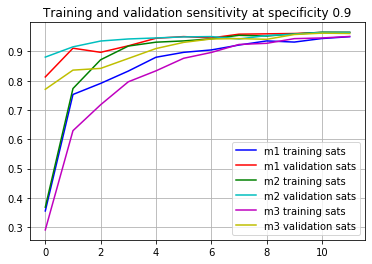

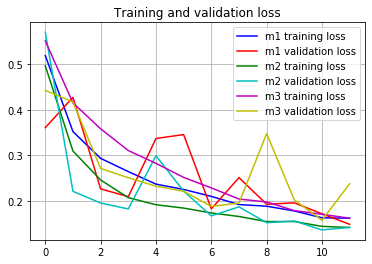

In [37]:
# Extract metrics

sats1 = h.history['sensitivity_at_specificity_1']
val_sats1 = h.history['val_sensitivity_at_specificity_1']
sats2 = h2.history['sensitivity_at_specificity_4']
val_sats2 = h2.history['val_sensitivity_at_specificity_4']
sats3 = h3.history['sensitivity_at_specificity_5']
val_sats3 = h3.history['val_sensitivity_at_specificity_5']

loss1 = h.history['loss']
val_loss1 = h.history['val_loss']
loss2 = h2.history['loss']
val_loss2 = h2.history['val_loss']
loss3 = h3.history['loss']
val_loss3 = h3.history['val_loss']

epochs = range(len(sats1))

# Plot sensitivity at specificity

plt.plot(epochs, sats1, 'b-', label='m1 training sats')
plt.plot(epochs, val_sats1, 'r-', label='m1 validation sats')
plt.plot(epochs, sats2, 'g-', label='m2 training sats')
plt.plot(epochs, val_sats2, 'c-', label='m2 validation sats')
plt.plot(epochs, sats3, 'm-', label='m3 training sats')
plt.plot(epochs, val_sats3, 'y-', label='m3 validation sats')

plt.title('Training and validation sensitivity at specificity 0.9')
plt.grid()
plt.legend()

# Plot loss

plt.figure()
plt.plot(epochs, loss1, 'b-', label='m1 training loss')
plt.plot(epochs, val_loss1, 'r-', label='m1 validation loss')
plt.plot(epochs, loss2, 'g-', label='m2 training loss')
plt.plot(epochs, val_loss2, 'c-', label='m2 validation loss')
plt.plot(epochs, loss3, 'm-', label='m3 training loss')
plt.plot(epochs, val_loss3, 'y-', label='m3 validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

# Results and Discussion

From the above graphs it can be concluded that all models perform well with model 2 having a slight advantage. It achieved the best figure for validation sensitivity of 96.49 % at specificity level of 90%. Validation loss was also smallest at 0.1421. Loss and sensitivity training values were also good.

Statistics for epoch 12 of model 2 training:

loss: 0.1417 - sensitivity_at_specificity_4: 0.9653 - val_loss: 0.1421 - val_sensitivity_at_specificity_4: 0.9649

Below we can take a look at confusion matrices & classification reports based on predictions of validation data.

In [46]:
# Confusion Matrices & Classification Reports

# Labels of validation data
labels = dev_generator.classes


# Model 1 predictions

# Predicted results
predicted1 = model.predict_generator(dev_generator).flatten()

print('Confusion matrix:')
cm = confusion_matrix(labels, predicted1 > 0.5)

tn1, fp1, fn1, tp1 = cm.ravel()
print(array([[tp1, fp1], [fn1, tn1]]))

cr = classification_report(labels, predicted1 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

Confusion matrix:
[[812  29]
 [ 43 288]]
               precision    recall  f1-score   support

   Normal (0)       0.87      0.91      0.89       317
Pneumonia (1)       0.97      0.95      0.96       855

     accuracy                           0.94      1172
    macro avg       0.92      0.93      0.92      1172
 weighted avg       0.94      0.94      0.94      1172



In [47]:
# Model 2 predictions

# Predicted results
predicted2 = model2.predict_generator(dev_generator).flatten()

print('Confusion matrix:')
cm2 = confusion_matrix(labels, predicted2 > 0.5)

tn2, fp2, fn2, tp2 = cm2.ravel()
print(array([[tp2, fp2], [fn2, tn2]]))

cr2 = classification_report(labels, predicted2 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr2)

Confusion matrix:
[[812  20]
 [ 43 297]]
               precision    recall  f1-score   support

   Normal (0)       0.87      0.94      0.90       317
Pneumonia (1)       0.98      0.95      0.96       855

     accuracy                           0.95      1172
    macro avg       0.92      0.94      0.93      1172
 weighted avg       0.95      0.95      0.95      1172



In [40]:
# Model 3 predictions

# Predicted results
predicted3 = model3.predict_generator(dev_generator).flatten()

print('Confusion matrix:')
cm3 = confusion_matrix(labels, predicted3 > 0.5)

tn3, fp3, fn3, tp3 = cm3.ravel()
print(array([[tp3, fp3], [fn3, tn3]]))

cr3 = classification_report(labels, predicted3 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr3)

Confusion matrix:
[[769  86]
 [ 13 304]]
               precision    recall  f1-score   support

   Normal (0)       0.78      0.96      0.86       317
Pneumonia (1)       0.98      0.90      0.94       855

     accuracy                           0.92      1172
    macro avg       0.88      0.93      0.90      1172
 weighted avg       0.93      0.92      0.92      1172



Model 2 achieved a validation accuracy of 95 %, sensitivity of 95 % and specificity of almost 94 %. Model 1 performance was also very close to this.

In [45]:
# Final evaluation and testing of the chosen model (model 2)

# Labels of test data
labels_test = test_generator.classes
# Predicted results on test images
predicted_b = model3.predict_generator(test_generator).flatten()

print('Confusion matrix:')
cm5 = confusion_matrix(labels_test, predicted_b > 0.5)

tn5, fp5, fn5, tp5 = cm5.ravel()
print(array([[tp5, fp5], [fn5, tn5]]))

cr5 = classification_report(labels_test, predicted_b > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr5)

Confusion matrix:
[[773  14]
 [ 82 303]]
               precision    recall  f1-score   support

   Normal (0)       0.79      0.96      0.86       317
Pneumonia (1)       0.98      0.90      0.94       855

     accuracy                           0.92      1172
    macro avg       0.88      0.93      0.90      1172
 weighted avg       0.93      0.92      0.92      1172



# Conclusions

It was possible to build a convolutional neural network that successfully predicts the presence or absence of pneumonia using x-ray images as a dataset. 

Even relatively simple network architectures achieved surprisingly good results. The best performing model was able to achieve an accuracy of 91.8 % when tested on previously unseen images, even though the overall number of images in the dataset was quite small. Sensitivity was 90.4 % and specificity was 95.6 %.